# CS171 - Winter 2022 - Assignment 2
### Instructor: Vagelis Papalexakis
### TA: Yorgos Tsitsikas

### Credit for  Assignment 2: 20/40 points of the final grade

In this assignment we will implement two different supervised learning models: 1) linear regression (using gradient descent), and 2) k-nearest neighbor classification. As we did in Assignment 1, here we will also use the Iris dataset. Below are some useful imports and some data bookkeeping:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import random as rand
from sklearn.model_selection import train_test_split
from collections import Counter
data_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'label']
data = pd.read_csv('iris.data', 
                   names = data_names)

## Question 1: Linear Regression [50%]
The first model we will implement is Linear Regression using Gradient Descent. 

###  Getting data
In order to properly test linear regression, we first need to find a set of correlated variables, so that we use one to predict the other. Consider the following scatterplots:

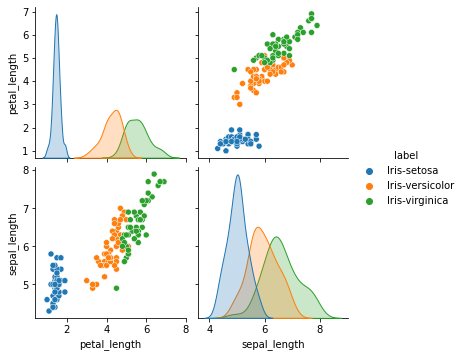

In [2]:
sb.pairplot(data[['petal_length','sepal_length','label']], hue = 'label')

We observe that sepal length and petal width for Iris-versicolor and Iris-virginica are reasonably correlated, so we are going to take those two variables for those two classes and use one to regress on the other.

In [3]:
sub_data = data.loc[data['label'] != 'Iris-setosa', :]
y = sub_data['petal_length'].values
x = sub_data['sepal_length'].values
x = x.reshape(-1, 1)

### Question 1a: Gradient descent for linear regression [40%]
As we saw in class, here we will implement the gradient descent version of linear regression.
In particular, the function implemented should follow the following format:
```python
def linear_regression_gd(x,y,learning_rate = 0.00001,max_iter=10000,tol=pow(10,-5)):
```
Where 'x' is the training data feature(s), 'y' is the variable to be predicted, 'learning_rate' is the learning rate used, 'max_iter' defines the maximum number of iterations that gradient descent is allowed to run, and 'tol' is defining the tolerance for convergence (which we'll discuss next).

The return values for the above function should be (at the least) 1) 'theta' which are the regression parameters, 2) 'all_cost' which is an array where each position contains the value of the objective function $J(\theta)$ for a given iteration, 3) 'iters' which counts how many iterations did the algorithm need in order to converge to a solution.

Gradient descent is an iterative algorithm; it keeps updating the variables until a convergence criterion is met. In our case, our convergence criterion is whichever of the following two criteria happens first:

- The maximum number of iterations is met
- The relative improvement in the cost is not greater than the tolerance we have specified. For this criterion, you may use the following snippet into your code:
```python
np.absolute(all_cost[it] - all_cost[it-1])/all_cost[it-1] <= tol
```

In [4]:
def linear_regression_gd(x, y, learning_rate = 0.00001, max_iter=10000, tol=pow(10,-5)):
    x = np.insert(x, 0, np.ones(x.shape[0]), axis=1)
    theta = np.zeros(x.shape[1])
    all_cost = []
    iters = 0;
    
    for it in range(max_iter):
        iters += 1
        theta += learning_rate * (y - np.transpose(x.dot(np.transpose(theta)))).dot(x)
        all_cost.append(0.5 * sum((y - np.transpose(x.dot(np.transpose(theta)))) ** 2))
        if(it and np.absolute(all_cost[it] - all_cost[it-1])/all_cost[it-1] <= tol):
            break
    
    return {"theta": theta,
            "all_cost": all_cost,
            "iters": iters}

### Question 1b: Convergence plots [10%]
After implementing gradient descent for linear regression, we would like to test that indeed our algorithm converges to a solution. In order see this, we are going to look at the value of the objective/loss function $J(\theta)$ as a function of the number of iterations, and ideally, what we would like to see is $J(\theta)$ drops as we run more iterations, and eventually it stabilizes. 

As we discussed in class, the learning rate plays a big role in how fast our algorithm converges: a larger learning rate means that the algorithm is making faster strides to the solution, whereas a smaller learning rate implies slower steps. In this question we are going to test two different values for the learning rate:
- 0.00001
- 0.000001

while keeping the default values for the max number of iterations and the tolerance.


- Plot the two convergence plots (cost vs. iterations) [5%]

- What do you observe? [5%]

<b>Important</b>: Remember that as we discussed in class, in reality, when we are running gradient descent, we should be checking convergence based on the <i>validation</i> error (i.e., we would have to split our training set into a e.g., 70/30 training'/validation subsets, use the new training' set to calculate the gradient descent updates and evaluate the error both on the training' set and the validation set, and as soon as the validation loss stops improving, we stop training. <b>In order to keep things simple, in this assignment we are only looking at the training loss</b>, but as long as you have a function 
```python
def compute_cost(x,theta,y):
```
that calculates the loss for a given x, y, and set of parameters you have, you can always compute it on the validation portion of x and y (that are <b>not</b> used for the updates).  

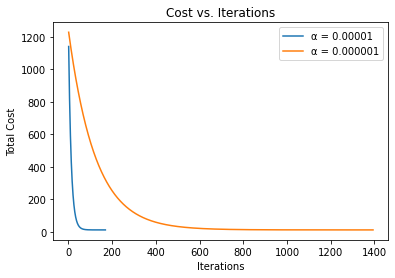

In [5]:
lr1 = linear_regression_gd(x, y)
lr2 = linear_regression_gd(x, y, 0.000001)
plt.plot(np.arange(1, lr1['iters'] + 1), lr1['all_cost'], label="\u03B1 = 0.00001")
plt.plot(np.arange(1, lr2['iters'] + 1), lr2['all_cost'], label="\u03B1 = 0.000001")
plt.xlabel("Iterations")
plt.ylabel("Total Cost")
plt.title("Cost vs. Iterations")
plt.legend()
plt.show()

The larger learning rate converged with less than 200 iterations while the smaller learning rate took almost 1,400 iterations.

## Question 2: K-Nearest Neighbors Classifier [50%]
The K-Nearest Neighbors Classifier is one of the most popular instance-based (and in general) classification models. In this question, we will implement our own version and test in different scenarios.

### Question 2a: Implement the K-NN Classifier [30%]
For the implementation, your function should have the format:
```python
def knnclassify(test_data,training_data, training_labels, K=1):
```
where 'test_data' contains test data points, 'training_data' contains training data points, 'training_labels' holds the training labels, and 'K' is the number of neighbors. 

The output of this function should be 'pred_labels' which contains the predicted label for each test data point (it should, therefore, have the same number of rows as 'test_data').

The piece of code below prepares the Iris dataset by converting the labels from strings to integers (which is quite easier to move around and do calculations with):

In [6]:
all_vals = data[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values
all_labels = data['label'].values
unique_labels = np.unique(all_labels)
#change string labels to numbers
new_labels = np.zeros(len(all_labels))
for i in range(0,len(unique_labels)):
    new_labels[all_labels == unique_labels[i]] = i
all_labels = new_labels

In [7]:
def to_list(x):
    return x if (type(x) is list or type(x) is np.ndarray) else [x]

def lp_norm(X, Y, p):
    tX = to_list(X)
    tY = to_list(Y)
    sum = 0
    for x, y in zip(tX, tY):
        sum += pow(abs(x - y), p)
    return pow(sum, 1 / p)

def knnclassify(test_data, training_data, training_labels, K=1):
    X = to_list(test_data)
    X_train = to_list(training_data)
    y_train = to_list(training_labels)
    y = []
    
    for test in test_data:
        d = [lp_norm(test, td, 2) for td in training_data]
        indices = np.argsort(d)[:K]
        nearest_labels = [y_train[i] for i in indices]
        vals, counts = np.unique(nearest_labels, return_counts=True)
        y.append(vals[np.argmax(counts)])
    
    return y

### Question 2b: Measuring performance [10%]

In this question you will have to evaluate the average performance of your classifier for different values of $K$. In particular, $K$ will range in $\{1,\cdots,8\}$. We are going to measure the performance using classification accuracy. For computing the accuracy, you may use
```python
accuracy = sum(test_labels == pred_labels)/len(test_labels)
```
where 'test_labels' are the actual class labels and 'pred_labels' are the predicted labels


In order to get a proper estimate for the accuracy for every K, we need to run multiple iterations where for each iteration we get a different randomized split of our data into train and test. In this question, we are going to run 100 iterations for every K, and for every random splitting, you may use:

```python
    (training_data, test_data, training_labels, test_labels) = train_test_split(all_vals, all_labels, test_size=0.3)
```
where the train/test ratio is 70/30. 

After computing the accuracy for every $K$ for every iteration, you will have 100 accuracies per $K$. The best way to store those accuracies is in a matrix that has as many rows as values for $K$ and 100 columns, each one for each iteration.

Compute average accuracy as a function of $K$. Because we have a randomized process, we also need to compute how certain/uncertain our estimation for the accuracy per $K$ is. For that reason, we also need to compute the standard deviation of the accuracy for every $K$. Having computed both average accuracy and standard deviation, make a figure that shows the average accuracy as a function of $K$ with each point of the figure being surrounded by an error-bar encoding the standard deviation. You may find 
```python
plt.errorbar()
```
useful for this plot.

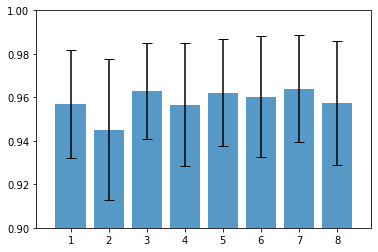

<Figure size 576x360 with 0 Axes>

In [8]:
from sklearn.model_selection import train_test_split

accuracies = []

for K in range(1, 9):
    accuracy = []
    for i in range(100):
        (training_data, test_data, training_labels, test_labels) = train_test_split(all_vals, all_labels, test_size=0.3)
        pred_labels = knnclassify(test_data, training_data, training_labels, K)
        accuracy.append(sum(test_labels == pred_labels)/len(test_labels))
    accuracies.append(accuracy)
        
average = [np.average(a) for a in accuracies]
std = [np.std(a) for a in accuracies]

plt.bar(np.arange(1,9), average, yerr=std, ecolor='black', capsize=5, alpha=0.75);
plt.axis([0.1, 8.9, 0.9, 1]);
plt.figure(figsize=(8,5));
plt.show();

### Question 2c: Feature selection [10%]

We have extensively discussed in class the fact that a good or bad set of features can make or break our model! Here we will see what happens when we operate on a subset of the features, and in particular in
- a subset that has good separability of classes
- a subset that has poor separability of classes

Recall from Assignment 1 where we did the scatterplots of the Iris dataset that a pair of features with high visual separability is (petal length, sepal width), whereas a set that confuses at least two classes is (sepal length, sepal width). 

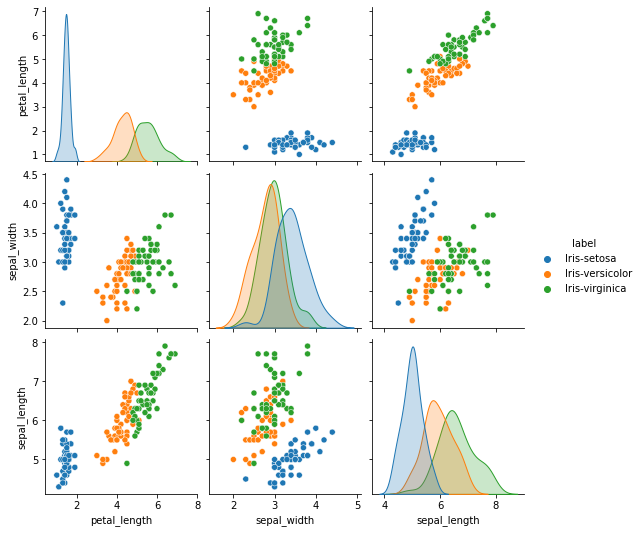

In [9]:
sb.pairplot(data[['petal_length','sepal_width','sepal_length','label']], hue = 'label')

Apply K-NN classification with K = 1 on two datasets (using the same train/test split for both datasets, and the same method you used to split as above) and measure the classification accuracy for:
- Only (petal length, sepal width) [2.5%]
- Only (sepal length, sepal width) [2.5%]

What do you observe regarding the classification accuracy? [5%]

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(data['label'])

(training_data, test_data, training_labels, test_labels) = train_test_split(data.iloc[:, :-1], data.iloc[:, -1], test_size=0.3)

training_data_1 = training_data[['petal_length', 'sepal_width']].values
test_data_1 = test_data[['petal_length', 'sepal_width']].values

training_data_2 = training_data[['sepal_length', 'sepal_width']].values
test_data_2 = test_data[['sepal_length', 'sepal_width']].values

training_labels = le.transform(training_labels)
test_labels = le.transform(test_labels)

pred_labels = knnclassify(test_data_1, training_data_1, training_labels, 1)
print('petal length and sepal width -> ', sum(test_labels == pred_labels)/len(test_labels))

pred_labels = knnclassify(test_data_2, training_data_2, training_labels, 1)
print('sepal length and sepal width -> ', sum(test_labels == pred_labels)/len(test_labels))

petal length and sepal width ->  0.9111111111111111
sepal length and sepal width ->  0.7333333333333333


The classification accuracy when using sepal length was lower compared to using petal length. This is expected as the sepal length and speal width for Iris-versicolor and Iris-virginica are similar to each other, which makes classification difficult between the two flowers. 